In [62]:
import pymongo
import os
import bson
import json
import glob
import pickle
import gridfs
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.sparse import csr_matrix
from os.path import join as opj
from tqdm import notebook
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
import sys

In [2]:
sys.path.append("..")
import dbfind

In [3]:
keyfile = '../6_database/credentials.key'
creds = open(keyfile, "r").read().splitlines()
myclient = pymongo.MongoClient('134.76.24.75', username=creds[0], password=creds[1], authSource='ohol') 
db = myclient.ohol

print(db)
print(db.list_collection_names())

Database(MongoClient(host=['134.76.24.75:27017'], document_class=dict, tz_aware=False, connect=True, authsource='ohol'), 'ohol')
['maplogs', 'tech_tree', 'lifelogs', 'maplogs_fixed', 'objects', 'expanded_transitions', 'transitions', 'activity_matrix.files', 'activity_matrix.chunks', 'activity_labels', 'categories']


## Import activity matrix chunks

In [4]:
# Get pointer from activity_matrix.files
activity_file = list(db.activity_matrix.files.find())
activity_id = activity_file[0]['_id']
print('File metadata:')
print(activity_file)


File metadata:
[{'_id': ObjectId('6085c6c1affb2a7f0bf57a44'), 'uploadDate': datetime.datetime(2021, 4, 25, 19, 48, 18, 502000), 'length': 412799872, 'chunkSize': 261120, 'md5': 'bdcad93c8ef343607e2019d4f188b200'}]


In [5]:
#Load sparse matrix. This takes about 30 seconds
fs = gridfs.GridFS(db, collection='activity_matrix')
activity_bin = fs.get(activity_id)
activity_mtx = pickle.load(activity_bin, encoding='latin1')
print('Loaded activity matrix:')
activity_mtx.shape

Loaded activity matrix:


(763682, 3044)

In [6]:
#Get item and avatar ids
itemIds = db.activity_labels.find_one()['items'] #item ids for each column of the sparse acrivity matrix
avatarIds = db.activity_labels.find_one()['avatars'] #avatar ids for each row of the sparse activity matrix

### Pre-processing

In [7]:
#Function to delete rows/columns
def delete_from_csr(mat, row_indices=[], col_indices=[]):
    """
    Remove the rows (denoted by ``row_indices``) and columns (denoted by ``col_indices``) from the CSR sparse matrix ``mat``.
    WARNING: Indices of altered axes are reset in the returned matrix
    """
    if not isinstance(mat, csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")

    rows = []
    cols = []
    if row_indices:
        rows = list(row_indices)
    if col_indices:
        cols = list(col_indices)

    if len(rows) > 0 and len(cols) > 0:
        row_mask = np.ones(mat.shape[0], dtype=bool)
        row_mask[rows] = False
        col_mask = np.ones(mat.shape[1], dtype=bool)
        col_mask[cols] = False
        return mat[row_mask][:,col_mask]
    elif len(rows) > 0:
        mask = np.ones(mat.shape[0], dtype=bool)
        mask[rows] = False
        return mat[mask]
    elif len(cols) > 0:
        mask = np.ones(mat.shape[1], dtype=bool)
        mask[cols] = False
        return mat[:,mask]
    else:
        return mat

#### Remove rows (avatars)

In [8]:
#exclusion list for players who didn't make it to adulthood or disconnected
exclusionIds = [q['avatar'] for q in db.lifelogs.find({"$or":[ {"age":{"$lt":14}}, {"cause_of_death":'disconnected'}]}, {'avatar'})]
len(exclusionIds) #note, not all overlapping with the ids in the activity matrix, since many of these never generated any map change data

627018

In [9]:
#Find the ids (rows in sparse activity_mtx) to delete
deleteIds = np.nonzero(np.in1d(avatarIds,exclusionIds))[0]
len(deleteIds)

101256

In [10]:
#Delete excluded avatars
activity_mtx = delete_from_csr(activity_mtx, row_indices = deleteIds.tolist())
for index in sorted(deleteIds.tolist(), reverse=True):
    del avatarIds[index]

In [11]:
#Check that all data is the right shape
print(activity_mtx.shape)
print(len(avatarIds))

(662426, 3044)
662426


#### Remove columns (items)

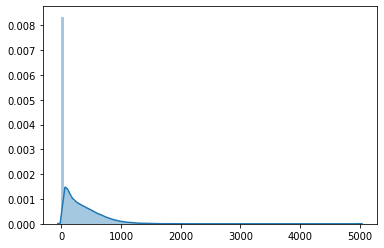

In [12]:
#look at distribution
sns.distplot(activity_mtx.sum(axis = 1), bins = 100) #histrogram of item iteractions

In [13]:
deleteIds = np.where(activity_mtx.sum(axis = 1)==0)[0]
deleteIds #Oh, there are no items with no interactions

array([], dtype=int64)

#### Finished preprocessing

In [14]:
jobMatrixCleaned = activity_mtx

### TF-IDF normalization

In [15]:
#Term frequency: let's use augmented frequency, which prevents a bias towards longer documents (i.e., players who have many item interactions)
#Each row vector v undergoes the following transformation:  tf(v) = 0.5 + (0.5*v)/(max(v))
TF = jobMatrixCleaned.toarray() #convert to array
TF = TF/jobMatrixCleaned.max(axis=1).toarray() #divide by max
TF *= 0.5 
TF += 0.5

In [21]:
#TODO: Some funny negative elements
#Inverse document frequency
#np.log(sum(itemVec)/len(itemVec[itemVec>0]))
IDFcolsums = jobMatrixCleaned.sum(axis = 1)
nonNegCounts = Counter(jobMatrixCleaned.nonzero()[1]) #Count non-negative elements in each column
nonNeg = np.zeros(jobMatrixCleaned.shape[1])
nonNeg[list(nonNegCounts.keys())] = list(nonNegCounts.values())
IDF = np.log(IDFcolsums / nonNeg)

In [56]:
#Multiply together
tfIdfMat = np.multiply(TF,IDF)

In [58]:
tfidfJobMatrix = jobMatrixCleaned.multiply(tfIdfMat)  #now compute tfidf

In [63]:
#Normalized rows
tfidfJobMatrixNormalized = normalize(tfidfJobMatrix, norm='l1', axis=0)

In [65]:
#Save as pickle, because that took a really long time to compute
with open('data/tfidfJobMatrixNormalized.pkl','wb') as f:
    pickle.dump(tfidfJobMatrixNormalized, f)

In [70]:
tfidfJobMatrixNormalized.toarray()

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.77317740e-07, -9.57204644e-07,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Non-negative matrix factorization

In [66]:
#Load from above
with open('data/tfidfJobMatrixNormalized.pkl','rb') as f:
    tfidfJobMatrixNormalized = pickle.load(f)
    print(tfidfJobMatrixNormalized.shape)

(662426, 3044)


In [67]:
model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(tfidfJobMatrixNormalized)
H = model.components_
#TODO: Save W and H matrices somewhere

ValueError: Negative values in data passed to NMF (input X)

Text(0.5, 69.0, 'Avatar')

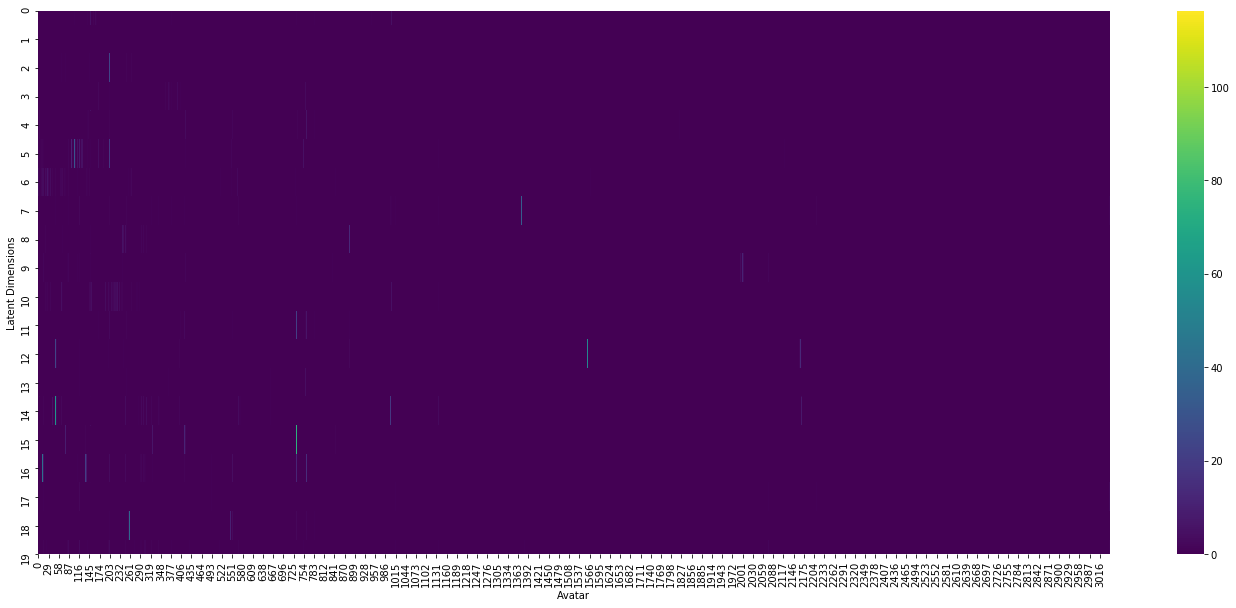

In [79]:
#How well can we allocate players to different latent dimensions?
plt.figure(figsize=(24, 10))
ax = sns.heatmap(H,  cmap="viridis") #x-axis are unique items and y-axis are the loadings
ax.set_ylabel('Latent Dimensions')
ax.set_xlabel('Item')

(array([2., 6., 3., 3., 2., 1., 1., 1., 0., 1.]),
 array([ 18.88107916,  66.62608896, 114.37109876, 162.11610856,
        209.86111837, 257.60612817, 305.35113797, 353.09614778,
        400.84115758, 448.58616738, 496.33117719]),
 <a list of 10 Patch objects>)

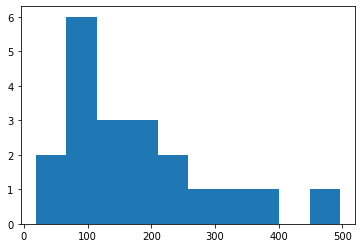

In [80]:
#What is the distribution of total loadings across items?
plt.hist(H.sum(axis = 1))

In [103]:
#Which items most strongly defined each component?
for C in range(H.shape[0]):
    comp = H[C,] #component
    items = comp.argsort()[-5:][::-1]#sort by weight; select the top 5 items
    print(C)
    for item in items:
        try:
            objname = dbfind.item(itemIds[item])[0][0] #relate to item id using the trimmed_idx, and then look up
            weight = str(comp[item])
            print(' : '.join([objname, weight]))
        except:
            print(' : '.join([str(int(item)), str(comp[item])]))
    print('')


0
Clay Bowl - empty : 6.8120444132321145
Clay Plate : 5.281318431345624
Stack of Clay Plates : 4.559362164510375
Stack of Clay Bowls : 3.5584275175042097
Raw Pie Crust : 2.9334422173128876

1
Escaped Horse-Drawn Tire Cart - just released : 8.488725047150051
Flat Rock - empty : 0.8530341793411949
Backpack : 0.44152544379150704
Fence - +wall +horizontalFence : 0.3584895484303478
3043 : 0.3404900610126829

2
Basket : 23.830429099410104
Clay : 1.1288218423954985
Bone Pile - origGrave : 0.9907219404843086
Clay Pit -partial : 0.9450639297972276
Canada Goose Pond : 0.6422782671203562

3
Bowl of Gooseberries - +yum31 : 69.33362279717113
Clay Bowl - empty : 11.089074911608215
Bowl of Gooseberries and Carrot : 8.191741410994128
Domestic Gooseberry Bush : 3.957838544459421
Empty Domestic Gooseberry Bush : 2.929986156466289

4
Fertile Soil Pile : 14.014829032191225
Deep Tilled Row - groundOnly : 8.571782502418305
Fertile Soil : 5.852950346590032
Clay Bowl - empty : 4.833579233972857
Shallow Tilled

In [99]:
comp = H[C,] #component
items = [itemIds[x] for x in comp.argsort()[-5:][::-1]]
dbfind.item(235)[0][0]

'Clay Bowl - empty'

In [101]:
comp

array([0.25288519, 0.        , 0.        , ..., 0.        , 0.        ,
       0.34049006])

items = itemIds